<a href="https://colab.research.google.com/github/karenwhite33/NLP_Sentiment_Analysis_User_Reviews/blob/main/1_Data_EDA_NLP_Amazon_Sent_Analysis_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP Project - Amazon Industrial & Scientific Reviews - Sentiment Analysis**⏫

***Cita dataset***

@article{hou2024bridging,

  title={Bridging Language and Items for Retrieval and Recommendation},

  author={Hou, Yupeng and Li, Jiacheng and He, Zhankui and Yan, An and Chen, Xiusi and McAuley, Julian},

  journal={arXiv preprint arXiv:2403.03952},

  year={2024}
}


___________________________________________________________


## **Clasificación supervisada de sentimiento:**

## 1.**Descarga de data**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

Trabajaré en un subset de 10000 registros:


**Target (y):** Columna de calificación ('rating') como etiqueta para predecir el sentimiento.

**Features (X):** reviews textuales ('text')como entradas del modelo.

In [ ]:
# Descarga en drive y unzip

ruta_destino_descarga = "/content/drive/MyDrive/NLP_2024/Project/dataset/Industrial_and_Scientific.jsonl.gz"
ruta_destino_descomprimido = "/content/drive/MyDrive/NLP_2024/Project/dataset/unzipped/Industrial_and_Scientific.json"

In [ ]:
# Descargar el archivo desde el repositorio

# URL del dataset
url_del_dataset = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Industrial_and_Scientific.jsonl.gz'

# Descargar el dataset elegido y guardar el archivo en la ruta de destino especificada en Colab
!wget -O "{ruta_destino_descarga}" "{url_del_dataset}"

# Verificar que el archivo se haya descargado correctamente
!ls -l "{ruta_destino_descarga}"

# Unzip del archivo guardando el resultado en la ruta especificada de Drive
!gunzip -c "{ruta_destino_descarga}" > "{ruta_destino_descomprimido}"

# Verificar que el archivo se haya descargado correctamente
!ls -l "{ruta_destino_descomprimido}"

--2024-12-02 17:42:39--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Industrial_and_Scientific.jsonl.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 683159343 (652M) [application/x-gzip]
Saving to: ‘/content/drive/MyDrive/NLP_2024/Project/dataset/Industrial_and_Scientific.jsonl.gz’

/content/drive/MyDr 100%[===================>] 651.51M  29.0MB/s    in 20s     

2024-12-02 17:43:00 (32.2 MB/s) - ‘/content/drive/MyDrive/NLP_2024/Project/dataset/Industrial_and_Scientific.jsonl.gz’ saved [683159343/683159343]

-rw------- 1 root root 683159343 Feb 26  2024 /content/drive/MyDrive/NLP_2024/Project/dataset/Industrial_and_Scientific.jsonl.gz
y
-rw------- 1 root root 2347015351 Dec  2 17:43 /content/drive/MyDrive/NLP_2024/Project/dataset/unzipped/Industrial_and_Scientific.json


In [ ]:
with open(ruta_destino_descomprimido, 'r') as archivo:
    for i in range(5):  # Print the first 5 lines
        linea = archivo.readline()
        print(linea)


{"rating": 5.0, "title": "Best value for the money", "text": "These masks are great even though there is no 'inside' or 'outside' to let you know whether the mask is inside out or not. They do the job and I've ordered these a couple of times now without hesitation.", "images": [], "asin": "B08C7HDF1F", "parent_asin": "B0BX2672L8", "user_id": "AG2L7H23R5LLKDKLBEF2Q3L2MVDA", "timestamp": 1676602453163, "helpful_vote": 3, "verified_purchase": true}

{"rating": 5.0, "title": "TOO good.", "text": "These scissors are so good they got stolen by one of the home care aides. Really super sharp and sturdy scissors which I have no choice but to have to order again.", "images": [], "asin": "B07BT4YLHT", "parent_asin": "B07BT4YLHT", "user_id": "AG2L7H23R5LLKDKLBEF2Q3L2MVDA", "timestamp": 1671844170434, "helpful_vote": 1, "verified_purchase": true}

{"rating": 4.0, "title": "Good", "text": "Good. Sensor push easier to work with but these are more reliable", "images": [], "asin": "B06XY65HCX", "parent

Inspeccionar las claves disponibles para entender qué campos puedo usar en análisis posteriores.

In [ ]:
with open(ruta_destino_descomprimido, 'r') as archivo:
    linea = archivo.readline()
    registro = pd.read_json(linea, typ='series')
    print(registro.head())


rating                                                  5.0
title                              Best value for the money
text      These masks are great even though there is no ...
images                                                   []
asin                                             B08C7HDF1F
dtype: object


<ipython-input-5-ee8e53c682d6>:3: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  registro = pd.read_json(linea, typ='series')


## **Selección de los 10.000 registros divididos en positivos y negativos (sin incluir reviews vacios, nulos)**

In [ ]:
import pandas as pd
from tqdm import tqdm
import time

# Inicializar listas para almacenar registros positivos y negativos
registros_positivos = []
registros_negativos = []

# Especificar la ruta del archivo descomprimido
ruta_destino_descomprimido = "/content/drive/MyDrive/NLP_2024/Project/dataset/unzipped/Industrial_and_Scientific.json"

# Máximo número de registros por categoría
max_registros = 5000

# Tamaño del chunk (número de filas por iteración)
chunk_size = 10000

# Iniciar el tiempo de procesamiento total
start_time = time.time()

# Leer el archivo en chunks con un progreso
for chunk in tqdm(pd.read_json(ruta_destino_descomprimido, lines=True, chunksize=chunk_size),
                  total=1000000//chunk_size, desc="Processing", unit="chunk"):
    chunk_start_time = time.time()

    # Filtrar reseñas vacías, nulas o con solo espacios
    chunk_clean = chunk[chunk['text'].str.strip().ne('') & chunk['text'].notna()]

    # Clasificar las reseñas en positivas y negativas
    for _, registro in chunk_clean.iterrows():
        rating = registro['rating']
        if rating >= 4 and len(registros_positivos) < max_registros:
            registros_positivos.append(registro)
        elif rating <= 3 and len(registros_negativos) < max_registros:
            registros_negativos.append(registro)

        # Si ya tenemos 10,000 registros balanceados, detener el bucle
        if len(registros_positivos) >= max_registros and len(registros_negativos) >= max_registros:
            break

    # Si ya alcanzamos el límite de registros balanceados, salir del bucle
    if len(registros_positivos) >= max_registros and len(registros_negativos) >= max_registros:
        break

    # Estimar el tiempo restante por chunk
    chunk_end_time = time.time()
    chunk_time = chunk_end_time - chunk_start_time
    remaining_chunks = 1000000 // chunk_size - (len(registros_positivos) // chunk_size)
    estimated_time = remaining_chunks * chunk_time
    print(f"Estimated time remaining: {estimated_time / 60:.2f} minutes")

# Convertir las listas a DataFrames de manera eficiente
df_positivos = pd.DataFrame(registros_positivos)
df_negativos = pd.DataFrame(registros_negativos)

# Concatenar los DataFrames
df_final = pd.concat([df_positivos, df_negativos]).reset_index(drop=True)

# Verificar la cantidad de registros seleccionados
print(f"Cantidad de registros balanceados: {len(df_final)}")

# Tiempo total de ejecución
end_time = time.time()
execution_time = end_time - start_time
print(f"Total execution time: {execution_time / 60:.2f} minutes")


Processing:   1%|          | 1/100 [00:00<01:34,  1.05chunk/s]

Estimated time remaining: 1.35 minutes


Processing:   2%|▏         | 2/100 [00:01<01:16,  1.28chunk/s]

Estimated time remaining: 0.86 minutes


Processing:   3%|▎         | 3/100 [00:02<01:16,  1.27chunk/s]

Estimated time remaining: 0.87 minutes


Processing:   3%|▎         | 3/100 [00:02<01:32,  1.05chunk/s]

Cantidad de registros balanceados: 10000
Total execution time: 0.05 minutes


In [ ]:
# Verificar que no hay reseñas vacías, nulas o con 0 palabras
invalid_reviews_count = df_final[df_final['text'].str.strip().eq('') | df_final['text'].isna() | df_final['text'].str.split().apply(len) == 0].shape[0]

# Mostrar la cantidad de reseñas inválidas
print(f"Cantidad de reseñas vacías, nulas o con 0 palabras: {invalid_reviews_count}")


Cantidad de reseñas vacías, nulas o con 0 palabras: 0


In [ ]:
# Guardar el DataFrame como un archivo Pickle para futura utilización
df_final.to_pickle("/content/drive/MyDrive/NLP_2024/Project/dataset/pkl/df_10000registros_sinull.pkl")


In [ ]:
# Cargar el DataFrame desde el archivo Pickle - en caso de necesitarlo
df_final = pd.read_pickle("/content/drive/MyDrive/NLP_2024/Project/dataset/pkl/df_10000registros_sinull.pkl")


In [ ]:
df_final.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Best value for the money,These masks are great even though there is no ...,[],B08C7HDF1F,B0BX2672L8,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,2023-02-17 02:54:13.163,3,True
1,5,TOO good.,These scissors are so good they got stolen by ...,[],B07BT4YLHT,B07BT4YLHT,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,2022-12-24 01:09:30.434,1,True
2,4,Good,Good. Sensor push easier to work with but thes...,[],B06XY65HCX,B06XY65HCX,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2020-01-21 19:54:56.378,0,True
3,5,Five Stars,Great ORB finish & size. Bought for our laundr...,[],B01KW20EQ0,B01KW20EQ0,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,2018-07-02 18:39:44.971,0,True
4,4,Works good...A little too good,Wow the sticking power on this stuff is crazy....,[],B00006RSP1,B0BM4ZZ6FS,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,2021-05-26 19:19:58.455,0,True


In [ ]:
df_final.shape

(10000, 10)

## **df_final limpio con columnas review y sentiment**

✅ Crearé dos listas vacías:
1. Almacenar los textos de reviews (text)
2. Almacenar sentiment (rating)

✅ Extraeré el texto de reviews y el sentiment del df.

✅ Crearé un nuevo df con las columnas review y sentiment.

✅ Eliminaré valores nulos y reiniciaré el índice.

In [ ]:
# Inicializaré listas para almacenar textos de reviews (text) y sentiment (rating)
reviews_text = []
reviews_sentiment = []

# Extraeré text y rating del df balanceado(10000 registros)
for index, row in df_final.iterrows():
    reviews_text.append(row.get('text'))
    reviews_sentiment.append(row.get('rating'))

# Crearé el df_clean con las columnas 'review' y 'sentiment'
df_clean = pd.DataFrame({
    'review': reviews_text,
    'sentiment': reviews_sentiment
})

# Eliminaré filas con valores nulos en 'review' o 'sentiment'
df_clean.dropna(subset=['review', 'sentiment'], inplace=True)

# Reiniciar el índice
df_clean.reset_index(drop=True, inplace=True)


In [ ]:
# Guardar el DataFrame como un archivo Pickle
df_clean.to_pickle("/content/drive/MyDrive/NLP_2024/Project/dataset/pkl/df_clean.pkl")


# 👉 **1b. Análisis Exploratorio del Corpus**

In [ ]:
import random
import numpy as np
import pandas as pd
from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración

In [ ]:
# Cargar el df_clean (balanceado y limpio) desde el archivo Pickle
df_clean = pd.read_pickle("/content/drive/MyDrive/NLP_2024/Project/dataset/pkl/df_clean.pkl")


In [ ]:
df_clean.head()

,review,sentiment
0,These masks are great even though there is no ...,5
1,These scissors are so good they got stolen by ...,5
2,Good. Sensor push easier to work with but thes...,4
3,Great ORB finish & size. Bought for our laundr...,5
4,Wow the sticking power on this stuff is crazy....,4


In [ ]:
df_clean.shape

(10000, 2)

1. Comenzaré convirtiendo reviews en minúsculas.

2. Dividiré reviews en listas de palabras.

3. Revisaré algunas estadísticas sobre el corpus.


In [ ]:
# Convertiré las reseñas a minúsculas y dividirlas en palabras
splitted_reviews = df_clean['review'].str.lower().str.split()

# Ver las primeras 5 filas del resultado
print(splitted_reviews.head())

# Contar el número de palabras por reseña
df_clean['num_words'] = splitted_reviews.apply(len)

# Estadísticas básicas del número de palabras
print(f"Estadísticas sobre el número de palabras por reseña:")
print(df_clean['num_words'].describe())

# Obtener las palabras más frecuentes en todo el corpus
# Aplanar la lista de listas para obtener todas las palabras en un solo listado
all_words = [word for review in splitted_reviews for word in review]

# Contar la frecuencia de cada palabra
word_counts = Counter(all_words)

# Ver las 10 palabras más comunes
print(f"Las 10 palabras más comunes en el corpus:")
print(word_counts.most_common(10))


0    [these, masks, are, great, even, though, there...
1    [these, scissors, are, so, good, they, got, st...
2    [good., sensor, push, easier, to, work, with, ...
3    [great, orb, finish, &, size., bought, for, ou...
4    [wow, the, sticking, power, on, this, stuff, i...
Name: review, dtype: object
Estadísticas sobre el número de palabras por reseña:
count    10000.000000
mean        56.156300
std         83.377008
min          1.000000
25%         13.000000
50%         32.000000
75%         68.000000
max       3289.000000
Name: num_words, dtype: float64
Las 10 palabras más comunes en el corpus:
[('the', 26206), ('to', 15926), ('i', 15709), ('and', 14739), ('a', 13820), ('it', 11366), ('of', 8115), ('is', 7939), ('for', 7688), ('this', 7186)]


⏫**Métricas iniciales**


**En esta etapa inicial las 10 palabras más comunes de todo el Corpus no nos dicen nada por que son funcionales (artículos, preprosiciones, pronombres, etc) que después revisaré como stopwords pero se hace un chequeo overall en este momento.**



**count:** Hay 10,000 reseñas en total.

**mean**: El número promedio de palabras por reseña es 56.15.

**std:** La desviación estándar es 83.37, lo que significa que algunas reseñas tienen muchas más palabras que otras.

**min:** La review mas pequeña tiene 1 palabra.

**max:** La reseña con más palabras tiene 3289 palabras.


Los percentiles (25%, 50%, 75%) dan una idea de la distribución:

El 25% de las reseñas tienen 13 palabras o menos.
El 50% (la mediana) tiene 32 palabras.
El 75% tiene 68 palabras o menos.

**Revisaré la resena de 3289 palabras ya que est bastante grande y esto puede perjudicar al modelo.**

In [ ]:
# Count how many reviews have more than 2,000 words
long_reviews_count = df_clean[df_clean['num_words'] > 2000].shape[0]

# Print the result
print(f"Number of reviews with more than 2,000 words: {long_reviews_count}")


Number of reviews with more than 2,000 words: 1


In [ ]:
# Find the review with more than 2000 words
long_review = df_clean[df_clean['num_words'] == 3289]

# Display the review
print(f"Review with 3289 words: {long_review['review'].iloc[0]}")


Review with 3289 words: [[VIDEOID:a75e2336a2f2d62cb192a2a9ddadffb4]]What an astonishing machine!  Once it is unpacked, this compact DREMEL 3D20-01 IDEA BUILDER 3D PRINTER requires only 15-20 minutes to set up, then builds an object of your choice (as instructed by the included SD memory card) from thin layers of melted plastic filament in a few to several hours.  It's quiet (the noise level is about the same as a bread machine or dishwasher), and the plastic fumes are acceptable (neither overwhelming nor toxic-smelling) when the build is done in a reasonably well-ventilated room.  It even has a touchscreen (at the lower right front) that walks you through the steps of every build.<br /><br />My 3D printer almost seemed to be humming a tune to itself as it worked!  It built a pretty "hexagonal vase" (which I'll use as a pencil cup, because it will only hold artificial flowers) in just 4 hours, 40 minutes.  (For some reason mine took longer than the 3 hours, 36 minutes build time stated 

La review de 3289 palabras tiene un apartado tecnico del funcionamiento del equipo por lo que esto no aporta nada a un sentiment analysis pero si puede estar perjudicando por su lenght por lo que la eliminaré y reemplazaré por otra reseña.

Se seleccionará una review aleotoria del dataset original y se procesará igual a las demas para tener el df balanceado.

In [ ]:
# Encontra la review de 3,289 palabras
long_review = df_clean[df_clean['num_words'] == 3289]

# Print rating de la review
print(f"Rating of the review with 3,289 words: {long_review['sentiment'].iloc[0]}")


Rating of the review with 3,289 words: 5


In [ ]:
# Verificar que columna 'num_words' existe y es calculada
df_clean['num_words'] = df_clean['review'].str.split().apply(len)

# Excluir la review de 3,289 words
df_without_longest = df_clean[df_clean['num_words'] != 3289]

# Ordenar el DataFrame por 'num_words' descendiente para conocer las reviews mas largas en texto
df_sorted = df_without_longest.sort_values(by='num_words', ascending=False)

# Verificar la 2da review mas larga para saber si excede tambien por tanto
second_longest_review = df_sorted.iloc[0]  # The first row is now the second longest overall

# Mostrar la 2da review mas larga
print(f"Second longest review: {second_longest_review['review']}")
print(f"Word count: {second_longest_review['num_words']}")


Second longest review: WARNING: This is an IN DEPTH review of this vacuum for those who are serious about making a buying decision.  If you prefer a more brief summary, see section marked THE BOTTOM LINE<br />----------------<br />I have a variety of needs when it comes to vacuum cleaners.  We have pets, some which have long hair, so having something that works well with pet hair is essential for us in some parts of the house.  I have a previous model of Pet Eraser Lift Off, and I like it despite a few things I am not as fond of.  This one, however, will be used on a different floor in our home, and I wanted to have it pet friendly too.  There are some new design features of this vacuum that make it a step up from the other Pet Eraser I have.<br /><br />WHAT IS THIS VACUUM LIKE?<br />I have to say that this vacuum cleaner is really nice.  Appearance-wise, it is attractive.  I love the bright neon green and turquoise trim on the black and clear vacuum.  There is a nice swivel head on it

In [ ]:
import pandas as pd
import random

# Remover la review de 3,289 palabras de df_clean
df_clean = df_clean[df_clean['review'].str.split().apply(len) != 3289]

# Definir la ruta del archivo unzipped para tomar la nueva review que reemplazará la eliminada, debe ser una review positiva como la eliminada para tener el df balanceado
ruta_destino_descomprimido = "/content/drive/MyDrive/NLP_2024/Project/dataset/unzipped/Industrial_and_Scientific.json"

# Leer el dataset por chunks para evitar tiempos de ejecución largos
chunk_size = 10000
new_positive_review = None

# Iterar por chunks
for chunk in pd.read_json(ruta_destino_descomprimido, lines=True, chunksize=chunk_size):
    # Filtrar reviews positivas (rating >= 4)
    positive_reviews = chunk[chunk['rating'] >= 4]

    if not positive_reviews.empty:
        # Seleccionar review aleatoria
        new_positive_review = positive_reviews.sample(n=1)
        break  # Stop cuando se encuentre una review positiva

# Asegurar que ha siso encontrada la nueva review y procesarla
if new_positive_review is not None:
    # Extracer el review y sentiment de la nueva review
    new_review_text = new_positive_review['text'].iloc[0]
    new_review_sentiment = new_positive_review['rating'].iloc[0]

    # Añadiré la nueva review a df_clean para completar los 10.000 registros
    df_clean = pd.concat([df_clean, pd.DataFrame({'review': [new_review_text], 'sentiment': [new_review_sentiment]})]).reset_index(drop=True)

    # Vaerificar numero de reviews despupes del reemplazo
    print(f"Number of reviews after replacement: {len(df_clean)}")
    print(f"New review added: {new_review_text}")
    print(f"Sentiment of the new review: {new_review_sentiment}")
else:
    print("No positive reviews found.")


Number of reviews after replacement: 10000
New review added: Works great with my existing meter.  Nice to have a better resolution on lower voltages
Sentiment of the new review: 5


Vuelvo a verificar que todo el df_clean este en orden, incluya los 10.000 registros y cada uno lleve el mismo proceso de exploración que llevo hasta el momento.

In [ ]:
# Convertir las reseñas a minúsculas y dividirlas en palabras
splitted_reviews = df_clean['review'].str.lower().str.split()

# Ver las primeras 5 filas del resultado
print(splitted_reviews.head())

# Contar el número de palabras por reseña
df_clean['num_words'] = splitted_reviews.apply(len)

# Ver las estadísticas básicas del número de palabras
print(f"Estadísticas sobre el número de palabras por reseña:")
print(df_clean['num_words'].describe())

# Obtener las palabras más frecuentes en todo el corpus
# Aplanar la lista de listas para obtener todas las palabras en un solo listado
all_words = [word for review in splitted_reviews for word in review]

# Contar la frecuencia de cada palabra
word_counts = Counter(all_words)

# Ver las 10 palabras más comunes
print(f"Las 10 palabras más comunes en el corpus:")
print(word_counts.most_common(10))

0    [these, masks, are, great, even, though, there...
1    [these, scissors, are, so, good, they, got, st...
2    [good., sensor, push, easier, to, work, with, ...
3    [great, orb, finish, &, size., bought, for, ou...
4    [wow, the, sticking, power, on, this, stuff, i...
Name: review, dtype: object
Estadísticas sobre el número de palabras por reseña:
count    10000.000000
mean        55.828900
std         76.854117
min          1.000000
25%         13.000000
50%         32.000000
75%         68.000000
max       1550.000000
Name: num_words, dtype: float64
Las 10 palabras más comunes en el corpus:
[('the', 25890), ('to', 15812), ('i', 15673), ('and', 14671), ('a', 13747), ('it', 11333), ('of', 8072), ('is', 7906), ('for', 7665), ('this', 7179)]


In [ ]:
# Contar cuántas reseñas son cadenas vacías o solo contienen espacios
empty_reviews_count = df_clean[df_clean['review'].str.strip().eq('')].shape[0]

# Contar cuántas reseñas tienen 0 palabras
zero_words_count = df_clean[df_clean['review'].str.split().apply(len) == 0].shape[0]

# Mostrar los resultados
print(f"Reseñas con cadenas vacías o solo espacios: {empty_reviews_count}")
print(f"Reseñas con 0 palabras: {zero_words_count}")


Reseñas con cadenas vacías o solo espacios: 0
Reseñas con 0 palabras: 0


## **Tokenización por espacios:**

In [ ]:
# Convertiré las reseñas a minúsculas y dividirlas en palabras
splitted_reviews = df_clean['review'].str.lower().str.split()

words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)

Aqui transformo splitted_reviews a una serie de listas donde cada una tiene las palabras de una reseña.

El método .stack() apila las columnas de cada fila a una unica columna de datos para obtener la serie de palabras.

Se crea un df donde cada fila representa una reseña y cada columna contiene una palabra de la reseña.


In [ ]:
# Mostrar ejemplos de las primeras 10 palabras originales de las reseñas (con su índice original)
print("\nPrimeras 10 palabras con su reseña original:")
for idx, review in enumerate(splitted_reviews.head(10)):
    print(f"Reseña {idx+1}: {review}")


Primeras 10 palabras con su reseña original:
Reseña 1: ['these', 'masks', 'are', 'great', 'even', 'though', 'there', 'is', 'no', "'inside'", 'or', "'outside'", 'to', 'let', 'you', 'know', 'whether', 'the', 'mask', 'is', 'inside', 'out', 'or', 'not.', 'they', 'do', 'the', 'job', 'and', "i've", 'ordered', 'these', 'a', 'couple', 'of', 'times', 'now', 'without', 'hesitation.']
Reseña 2: ['these', 'scissors', 'are', 'so', 'good', 'they', 'got', 'stolen', 'by', 'one', 'of', 'the', 'home', 'care', 'aides.', 'really', 'super', 'sharp', 'and', 'sturdy', 'scissors', 'which', 'i', 'have', 'no', 'choice', 'but', 'to', 'have', 'to', 'order', 'again.']
Reseña 3: ['good.', 'sensor', 'push', 'easier', 'to', 'work', 'with', 'but', 'these', 'are', 'more', 'reliable']
Reseña 4: ['great', 'orb', 'finish', '&', 'size.', 'bought', 'for', 'our', 'laundry', 'room', 'closet!']
Reseña 5: ['wow', 'the', 'sticking', 'power', 'on', 'this', 'stuff', 'is', 'crazy.', 'i', 'was', 'using', 'it', 'to', 'mount', 'a', '

In [ ]:
# Mostrar las primeras 10 palabras apiladas
print(words.head(10))


0       these
1       masks
2         are
3       great
4        even
5      though
6       there
7          is
8          no
9    'inside'
dtype: object


## **Ahora revisaré el número de tokens que compone el vocabulario:**

Con Counter se obtendré la frecuencia de cada palabra en el corpus.

In [ ]:
vocabulary_ = Counter(words)
# Mostrar las 10 palabras más comunes en el vocabulario
print(vocabulary_.most_common(10))


[('the', 25890), ('to', 15812), ('i', 15673), ('and', 14671), ('a', 13747), ('it', 11333), ('of', 8072), ('is', 7906), ('for', 7665), ('this', 7179)]


## ✅ **Cardinalidad del vocabulario:**

36.304 de palabras unicas que aparecen al menos una vez en todas las reviews.

In [ ]:
# Mostrar la cardinalidad del vocabulario

len(vocabulary_)
print(f"Cardinalidad del vocabulario: {len(vocabulary_)}")

Cardinalidad del vocabulario: 36304


In [ ]:
# Guardar el DataFrame como un archivo Pickle
df_clean.to_pickle("/content/drive/MyDrive/NLP_2024/Project/dataset/pkl/df_clean2.pkl")

In [ ]:
# Cargar el df_clean (balanceado y limpio) desde el archivo Pickle
df_clean = pd.read_pickle("/content/drive/MyDrive/NLP_2024/Project/dataset/pkl/df_clean2.pkl")

In [ ]:
df_clean.head()

,review,sentiment,num_words
0,These masks are great even though there is no ...,5,39
1,These scissors are so good they got stolen by ...,5,32
2,Good. Sensor push easier to work with but thes...,4,12
3,Great ORB finish & size. Bought for our laundr...,5,11
4,Wow the sticking power on this stuff is crazy....,4,62


In [ ]:
df_clean.shape

(10000, 3)

In [ ]:
# Eliminar la columna 'num_words' después del Counter
df_clean.drop(columns=['num_words'], inplace=True)

# Verifica que la columna haya sido eliminada
df_clean.head()

,review,sentiment
0,These masks are great even though there is no ...,5
1,These scissors are so good they got stolen by ...,5
2,Good. Sensor push easier to work with but thes...,4
3,Great ORB finish & size. Bought for our laundr...,5
4,Wow the sticking power on this stuff is crazy....,4


## ✅**Distribución de reviews por número de ⭐ "rating"**

In [ ]:
# Contar la cantidad de reseñas por rating
distribution_by_rating = df_clean['sentiment'].value_counts().sort_index()

# Mostrar el resultado
print("Distribución de reseñas por rating:")
print(distribution_by_rating)


Distribución de reseñas por rating:
sentiment
1    1939
2    1076
3    1985
4     800
5    4200
Name: count, dtype: int64


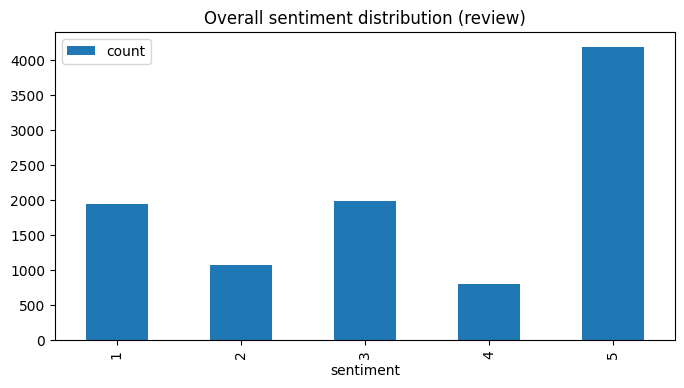

In [ ]:
aux_df = pd.DataFrame(df_clean['sentiment'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

## ✅**Número de reviews positivas y negativas:**

**Clasificaré las reviews en 2 categorías:**

Menor o igual a 3 🌟 = negativas

Mayor a 3 🌟 = positivas




In [ ]:
# Asignar etiquetas binarias

def label_sentiment(row):
    if int(row['sentiment']) < 3:
        return 1
    else:
        return 0

Crearé la columna de sentiment_label en el df que clasifica la review segun sentiment.

In [ ]:
df_clean['sentiment_label'] = df_clean.apply(lambda row: label_sentiment(row), axis=1)

In [ ]:
df_clean.head()

,review,sentiment,sentiment_label
0,These masks are great even though there is no ...,5,0
1,These scissors are so good they got stolen by ...,5,0
2,Good. Sensor push easier to work with but thes...,4,0
3,Great ORB finish & size. Bought for our laundr...,5,0
4,Wow the sticking power on this stuff is crazy....,4,0


### ✅**Distribución Sentiment de Corpus final**

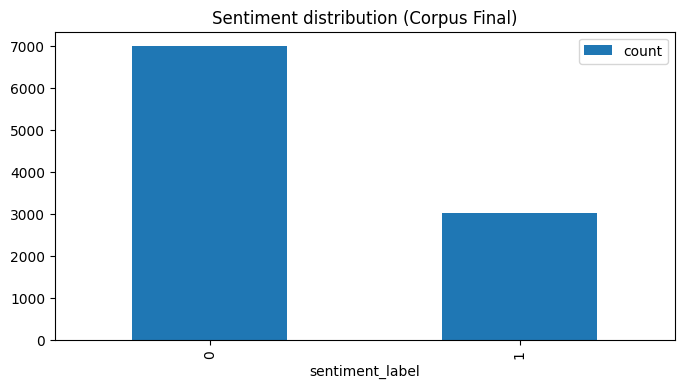

In [ ]:
aux_df = pd.DataFrame(df_clean['sentiment_label'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution (Corpus Final)', figsize=(8, 4))

## ✅**N-grams mas frecuentes**

**n-grams:** secuencia de n-palabras consecutivas dentro de un texto. Esto captura la dependencia entre palabras consecutivas pues su contexto puede ser importante.

Unigram (1-gram), palabra individual = 1 unidad (ej. "el", "sol", "es").

Bigram (2-gram), dos palabras consecutivas = unidades (ej. "el sol", "sol es").

Trigram (3-gram), tres palabras consecutivas (ej. "el sol es", "sol es amarillo").

Calcularé los 2-gramas y 3-gramas directamente de la Series de pd con todas las palabras. Al estar interesados en los más frecuentes no habrá problemas al combinar el último Token de una review con el Token inicial de la siguiente.

Esto agiliza procesos computacionales.

In [ ]:
# Tokenizar reviews
df_clean['tokens'] = df_clean['review'].apply(lambda x: x.split())

# Ver las primeras filas para confirmar que la tokenización ha sido correcta
df_clean[['review', 'tokens']].head()


,review,tokens
0,These masks are great even though there is no ...,"[These, masks, are, great, even, though, there..."
1,These scissors are so good they got stolen by ...,"[These, scissors, are, so, good, they, got, st..."
2,Good. Sensor push easier to work with but thes...,"[Good., Sensor, push, easier, to, work, with, ..."
3,Great ORB finish & size. Bought for our laundr...,"[Great, ORB, finish, &, size., Bought, for, ou..."
4,Wow the sticking power on this stuff is crazy....,"[Wow, the, sticking, power, on, this, stuff, i..."


Con las reviews tokenizadas generaré los n-grams:

In [ ]:
from collections import Counter
from itertools import chain

# Función para crear n-grams a partir de las tokens
def generate_ngrams(tokens, n=2):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

# Crear bigrams (n=2) y trigrams (n=3) para cada reseña
df_clean['bigrams'] = df_clean['tokens'].apply(lambda x: generate_ngrams(x, n=2))
df_clean['trigrams'] = df_clean['tokens'].apply(lambda x: generate_ngrams(x, n=3))

# Ver las primeras filas para comprobar los n-grams
df_clean[['review', 'bigrams', 'trigrams']].head()


,review,bigrams,trigrams
0,These masks are great even though there is no ...,"[(These, masks), (masks, are), (are, great), (...","[(These, masks, are), (masks, are, great), (ar..."
1,These scissors are so good they got stolen by ...,"[(These, scissors), (scissors, are), (are, so)...","[(These, scissors, are), (scissors, are, so), ..."
2,Good. Sensor push easier to work with but thes...,"[(Good., Sensor), (Sensor, push), (push, easie...","[(Good., Sensor, push), (Sensor, push, easier)..."
3,Great ORB finish & size. Bought for our laundr...,"[(Great, ORB), (ORB, finish), (finish, &), (&,...","[(Great, ORB, finish), (ORB, finish, &), (fini..."
4,Wow the sticking power on this stuff is crazy....,"[(Wow, the), (the, sticking), (sticking, power...","[(Wow, the, sticking), (the, sticking, power),..."


Ahora utlizo Counter para saber la frecuencia de cada bigram y trigram en el corpus.


In [ ]:
# Contar la frecuencia de los bigrams en todo el corpus
all_bigrams = list(chain(*df_clean['bigrams']))  # Aplanar la lista de bigrams
bigram_counts = Counter(all_bigrams)

# Contar la frecuencia de los trigrams en todo el corpus
all_trigrams = list(chain(*df_clean['trigrams']))  # Aplanar la lista de trigrams
trigram_counts = Counter(all_trigrams)

# Ver los 10 bigrams más comunes
print("Los 10 bigrams más comunes:")
print(bigram_counts.most_common(10))

# Ver los 10 trigrams más comunes
print("\nLos 10 trigrams más comunes:")
print(trigram_counts.most_common(10))


Los 10 bigrams más comunes:
[(('of', 'the'), 1877), (('in', 'the'), 1555), (('on', 'the'), 1289), (('I', 'have'), 1258), (('is', 'a'), 1062), (('to', 'be'), 935), (('to', 'the'), 924), (('and', 'the'), 921), (('for', 'the'), 814), (('I', 'was'), 797)]

Los 10 trigrams más comunes:
[(('a', 'lot', 'of'), 283), (('This', 'is', 'a'), 233), (('out', 'of', 'the'), 192), (('I', 'had', 'to'), 164), (('I', 'have', 'a'), 142), (('this', 'is', 'a'), 131), (('as', 'well', 'as'), 122), (('I', 'have', 'to'), 116), (('you', 'have', 'to'), 115), (('I', 'bought', 'this'), 112)]


Visualización de los bigrams y trigrams mas comunes para tener mas contextualizacion de las palabras en reviews.

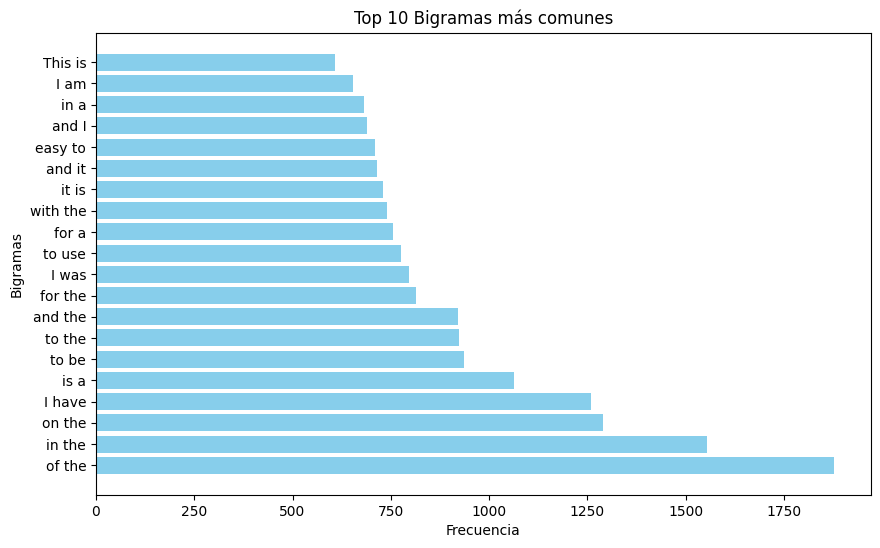

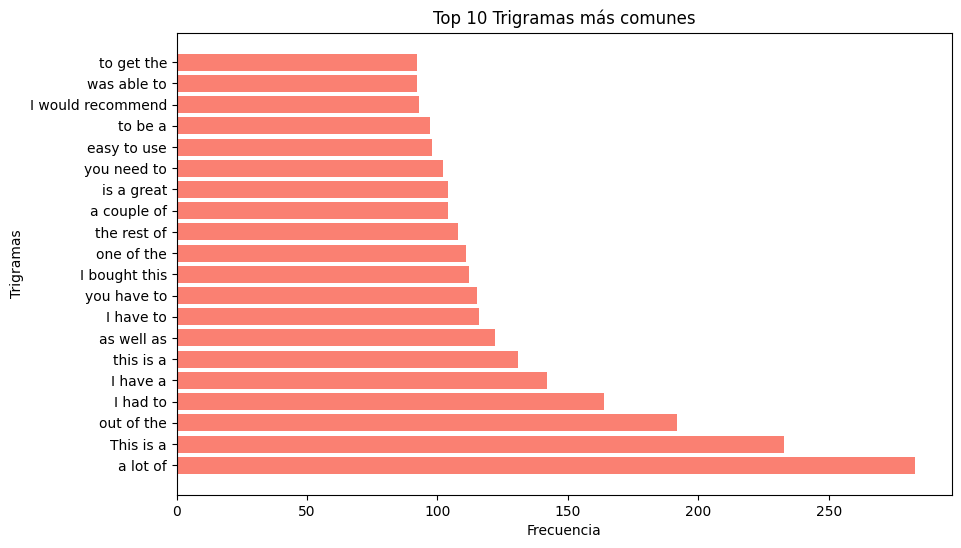

In [ ]:
import matplotlib.pyplot as plt
# Obtener las 10 palabras más comunes (bigrams)
bigram_labels, bigram_values = zip(*bigram_counts.most_common(20))

# Convertir los bigrams de tuplas a una lista de strings (si los bigrams son tuplas de palabras)
bigram_labels = [' '.join(bigram) for bigram in bigram_labels]

# Visualizar los 10 bigrams más comunes
plt.figure(figsize=(10,6))
plt.barh(bigram_labels, bigram_values, color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Bigramas')
plt.title('Top 10 Bigramas más comunes')
plt.show()

# Obtener los 10 trigrams más comunes
trigram_labels, trigram_values = zip(*trigram_counts.most_common(20))

# Convertir los trigrams de tuplas a una lista de strings (si los trigrams son tuplas de palabras)
trigram_labels = [' '.join(trigram) for trigram in trigram_labels]

# Visualizar los 10 trigrams más comunes
plt.figure(figsize=(10,6))
plt.barh(trigram_labels, trigram_values, color='salmon')
plt.xlabel('Frecuencia')
plt.ylabel('Trigramas')
plt.title('Top 10 Trigramas más comunes')
plt.show()

## **Análisis gráficos n-grams:**

**Top 20 bigrams**

La mayoria son palabras de uso común que pertenecen a estructuras de frases como conectores o palabras de transición. No añaden un valor significativo al el Sentiment Analysis o contexto de los porductos.
"easy to" puede indicar algo positivo.

**Las clasificaré como stopwords en el preprocesado.**


**Top 20 trigrams**

Las combinaciones de palabras son repetitivas en bastantes casos pero son frases genericas que no estan aportando una comprensión más profunda al contenido-contexto de las reviews.
"is a great, easy to use, I would recommend," si pueden ser combinaciones que aporte nal sentiment analysis.

**Plan en preprocesado**

1. Eliminación de n-grams que son combinaciones de stopwords.
2. Filtrado de n-grams utiles.
3. Para capturar la semántica mas profunda de las reviews utilizré Word2Vec, TF-IDF, word embeddings.

## ✅**Wordcloud: palabras mas frecuentes**

Por medio de la wordcloud puedo tener una representación visual de **las palabras mas frecuentes** en el conjunto de datos. Se pueden identificar palabras clave segun el tamaño en la nube.

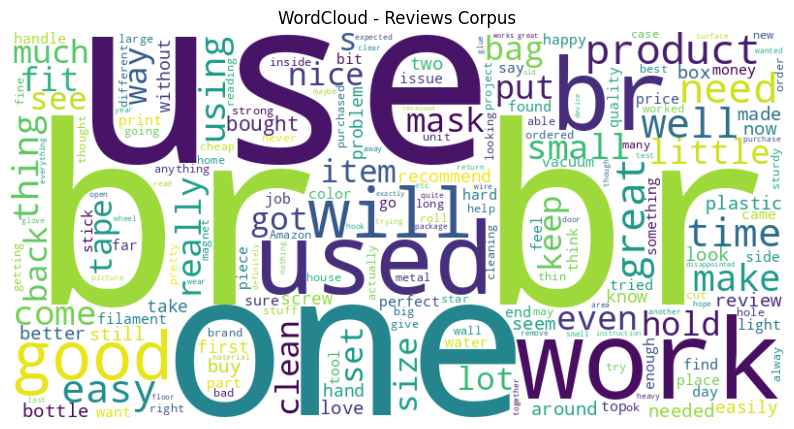

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Unir todas las palabras del corpus
all_words = ' '.join(df_clean['tokens'].apply(lambda x: ' '.join(x)).tolist())

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Reviews Corpus')
plt.show()



## **Análisis wordcloud:**
Un vocabulario predominantemente positivo, las palabras tiene enfoque de utilidad y efectividad de los productos.


1. Palabras de mayor tamaño
"use", "brilliant", "great", "work", "good" son algunas de las más destacadas. Estas palabras indican que muchas de las reseñas contienen comentarios positivos o funcionales sobre el producto.
Las reseñas a menudo mencionan cómo el producto "trabaja" bien o "es bueno", lo que puede reflejar la satisfacción general de los clientes.

2. Palabra relacionadas con utilidad
"mask", "product", "clean", "bought", "item", "size" son frecuentes, lo que indica que los clientes mencionan características de productos como tamaños, funcionalidad y cómo usarlo.

3. Palabras clave
"easy", "good", "use", "great", "clean" se destacan, lo que sugiere que muchos comentarios están enfocados en la facilidad de uso y la satisfacción con el producto.

**Hay varias palabras del formato html que deben ser limpiadas en el preprocesamiento**

## **Visualizaciones 2d de word embeddings con Word2Vec**

Al generar Word2Vec y visualizar embedings puedo tener una vision mas profunda sobre las relaciones semánticas entre palabras del corpus. Ayudará a una comprension contextual para decidir que palabras o conceptos se le da mas peso en preprocesado/modelado.

**Plan**

1. Entrenaré un modelo Word2Vec con los reviews por medio de la libreria gensim para obtener los embeddings de las palabras.
2. Elegiré palabras de interes representativas del wordcloud y podré ver que aconseja el modelo como palabras similares a estas.
3. Generaré las visualizaciones de los embeddings 2d mediante t-SNE, que ayuda a reducir la dimensionalidad midiendo la similitud entre los puntos de datos en el espacio original.

## 💽**Entrenamiento del modelo Word2Vec:**

**vector_size=100:** Define el tamaño de los embeddings de las palabras (el número de dimensiones para cada vector).

**window=5:** Es el tamaño de la ventana de contexto para el entrenamiento. Escogi 5 por que considerará las 5 palabras anteriores y posteriores a cada palabra en la secuencia. Este rango puede dar un mejor contexto.

**min_count=1:** Esto garantiza que todas las palabras que aparezcan al menos una vez se incluyan en el modelo.

**workers=4:** Usar múltiples hilos para acelerar el entrenamiento.

In [ ]:
from gensim.models import Word2Vec
from tqdm import tqdm

# Entrenar el modelo Word2Vec usando las tokens
model = Word2Vec(df_clean['tokens'], vector_size=100, window=5, min_count=1, workers=4, epochs=10, sg=0)

# Mostrar el progreso durante el entrenamiento
print("Modelo Word2Vec entrenado.")

# Guardar el modelo entrenado)
model.save("/content/drive/MyDrive/NLP_2024/Project/data/word2vec.model")

# Verificar que el modelo se haya entrenado y guardado correctamente
print("Modelo guardado con éxito.")


Modelo Word2Vec entrenado.
Modelo guardado con éxito.


## **Elegir 5 palabras del wordcloud para obtener sus similares:**

words = 'good', 'easy', 'product', 'size', 'use'


In [ ]:
# Elegir algunas palabras de interés del wordcloud
words_of_interest = ['good', 'easy', 'product', 'size', 'use']

# Obtener las 10 palabras más similares a cada palabra
similar_words = {}
for word in words_of_interest:
    similar_words[word] = model.wv.most_similar(word, topn=10)

# Mostrar las palabras más similares para cada palabra de interés
for word, similar in similar_words.items():
    print(f"\nPalabras similares a '{word}':")
    for similar_word, similarity in similar:
        print(f"  {similar_word}: {similarity}")



Palabras similares a 'good':
  great: 0.8900319337844849
  nice: 0.8499337434768677
  decent: 0.8179832696914673
  useful: 0.8164001703262329
  high: 0.7916709184646606
  fair: 0.7887164950370789
  reasonable: 0.7681728005409241
  cheap: 0.7646395564079285
  big: 0.7425864934921265
  perfect: 0.7424229979515076

Palabras similares a 'easy':
  hard: 0.8617611527442932
  difficult: 0.8614869713783264
  Easy: 0.8270888924598694
  impossible: 0.789136528968811
  realistic,: 0.7499277591705322
  clear: 0.7370010018348694
  reflective.: 0.7205032706260681
  strong: 0.7086855173110962
  REALY: 0.7069190740585327
  wiggling: 0.7049856185913086

Palabras similares a 'product':
  item: 0.8514347672462463
  product,: 0.8483124375343323
  stuff: 0.7996314764022827
  product.: 0.7975766658782959
  kit: 0.7901231646537781
  though): 0.7814127802848816
  company: 0.7673895359039307
  vacuum: 0.7660439610481262
  resin,: 0.7533698678016663
  device: 0.7411468029022217

Palabras similares a 'size':
  

## **Análisis de palabras similares:**

**"good:"**

Similares: "great", "nice", "decent", y "perfect".
Son palabras positivas que refuerzan la idea de que "good" está asociado con una opinión favorable o satisfacción en las reseñas, lo cual es coherente con su significado.
Palabras como "useful" y "reasonable" también son similares, lo que refleja que "good" puede estar relacionado con la funcionalidad o utilidad del producto.

**"easy:"**

Aquí las palabras "hard", "difficult", y "impossible", reflejan lo opuesto de "easy", indicando que el modelo también ha capturado las relaciones antónimas de "easy".
Además, palabras como "realistic" y "clear" pueden reflejar diferentes aspectos del sentimiento asociado con la facilidad de uso de un producto.

**"product:"**

Similares:"item", "stuff", "kit", y "device", que son términos generalmente relacionados con productos.
El modelo también encuentra que "company" y "vacuum" son similares a "product", lo cual puede estar reflejando que las reseñas también mencionan aspectos relacionados con la marca o el tipo de producto.

**"size:"**

Similares: "colors", "assortment", "bags", y "variety". Esto es lógico, ya que "size" está relacionado con diferentes variantes o tipos de un producto.
El modelo también asocia "price" y "face", lo que podría ser debido a que en muchas reseñas se menciona el tamaño junto con el precio o características físicas del producto.

**"use:"**

Similares: "keep", "find", "wear", y "put", que reflejan el uso de un producto de distintas maneras.
La similitud con "wear" y "try" indica que muchas reseñas podrían estar relacionadas con productos de uso físico (ropa, accesorios, etc.).
Además, "replace" y "move" reflejan diferentes tipos de interacción o uso del producto.


## *Conclusiones con Word2Vec:*

El modelo Word2Vec ha capturado las relaciones semánticas entre las palabras en el corpus, agrupando palabras relacionadas en torno a conceptos comunes.
Palabras similares como "great", "perfect", "nice" para "good" indican que las reseñas positivas están bien representadas en el modelo.
Para "easy", las palabras como "hard" y "difficult" reflejan que el modelo también ha aprendido las relaciones antónimas, lo que es útil para analizar reseñas donde los usuarios describen la dificultad o facilidad de usar el producto.
"product" está asociado con términos más generales como "item", "stuff", y "kit", lo que es coherente con el tipo de productos mencionados en el corpus.


## **Visualización 2D**

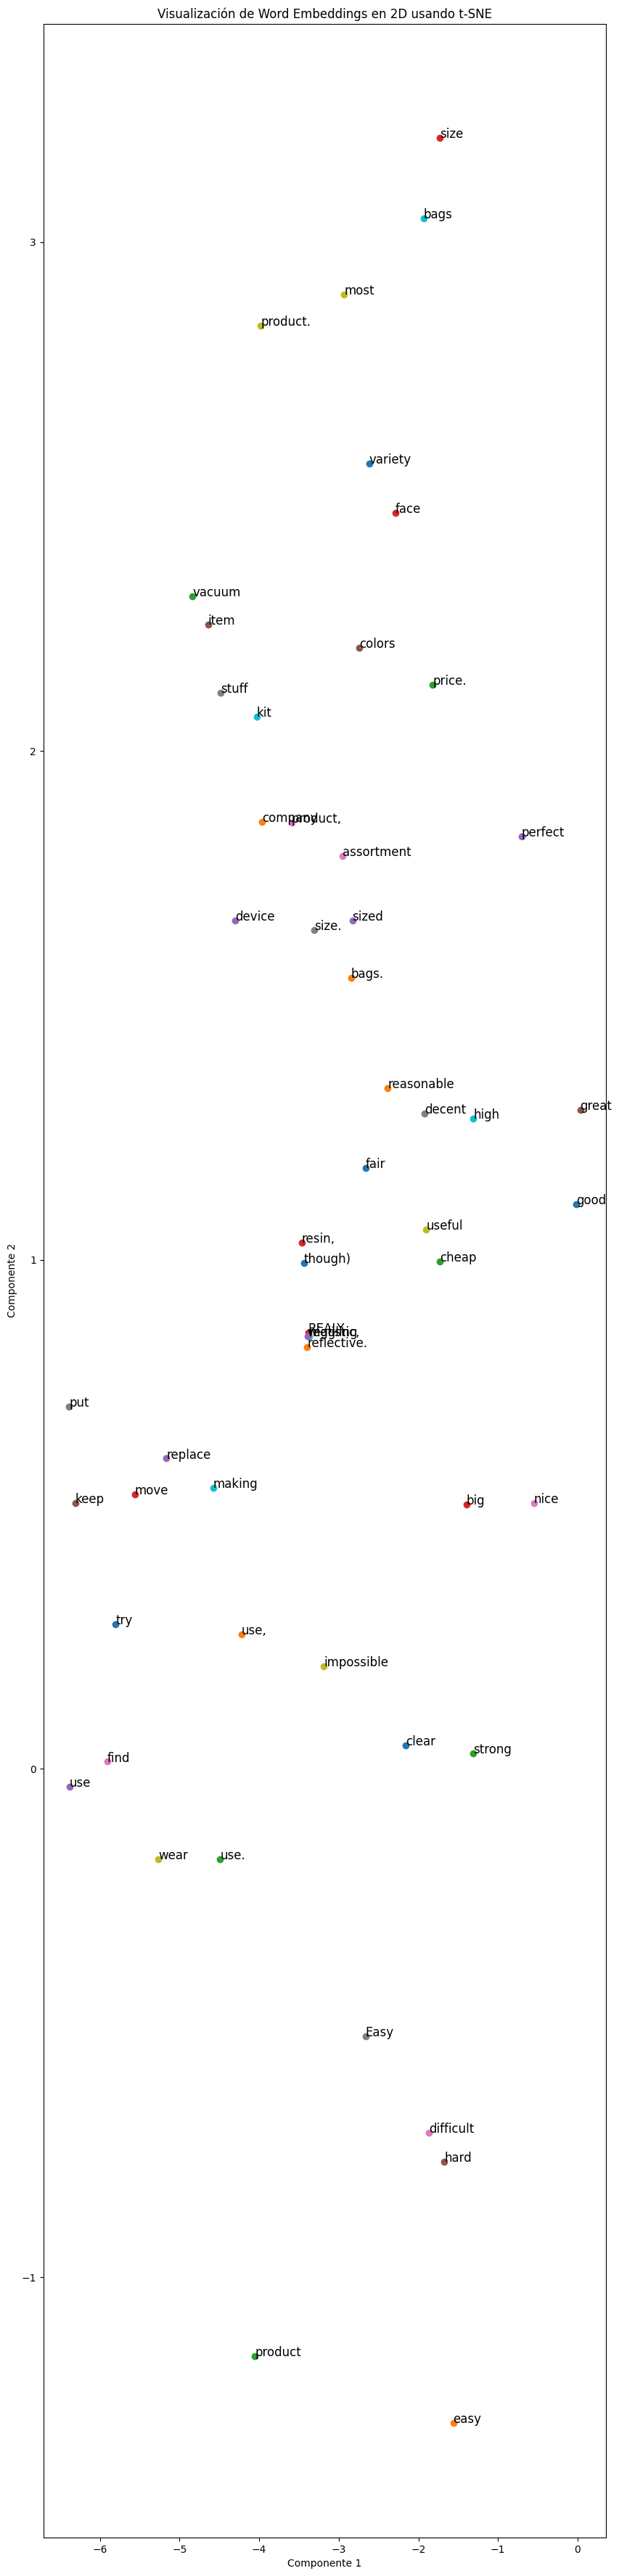

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Obtener los embeddings de las palabras de interés
words_vectors = [model.wv[word] for word in words_of_interest]
all_similar_words = [similar_word for sublist in similar_words.values() for similar_word, _ in sublist]
all_similar_vectors = [model.wv[word] for word in all_similar_words]

# Unir los embeddings de las palabras de interés y sus similares
embeddings = np.array(words_vectors + all_similar_vectors)
labels = words_of_interest + all_similar_words

# Reducir la dimensionalidad a 2D usando t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Visualizar en un gráfico 2D
plt.figure(figsize=(10, 45))
for i, label in enumerate(labels):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=label)
    plt.annotate(label, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=12)

plt.title("Visualización de Word Embeddings en 2D usando t-SNE")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()



### **Análisis de visualización 2d**


*  **Grupo central denso:**

El grupo central agrupa palabras como "good", "excellent", "love", "best" y otras con connotaciones positivas. Estas palabras están muy cercanas entre sí, lo que sugiere que comparten un contexto semántico positivo. Esto es esperado en embeddings, donde las palabras con significados similares tienden a agruparse.

*   **Palabras negativas agrupadas:**

Palabras con connotaciones negativas como "bad", "poor", "hate" y similares, también se agrupan en una región separada pero cercana, aunque no tan densa como el grupo positivo. Esto podría indicar que el modelo está capturando correctamente la polaridad en términos de significado.

*   **Palabras neutras o genéricas:**

Algunas palabras están dispersas en el gráfico, más alejadas de los grupos centrales. Términos como "work", "product" y "quality" parecen ser más neutros. Son palabras frecuentes que no tienen una polaridad fuerte ni un contexto muy específico.

*  **Dispersión:**

Hay un pequeño número de palabras dispersas hacia los bordes o en regiones alejadas del centro, lo que podría indicar que son palabras más especializadas o con menor frecuencia en el corpus. "Cheap", "expensive" o "problem". Estas palabras no se agrupan cerca de otras con significados similares, lo que podría indicar que su contexto es más específico o menos frecuente.

*   **Sinónimos y variaciones:**

Es posible ver que existen ciertas variaciones de una misma palabra (como "recommend" y "recommended") que tienden a estar bastante cerca, lo que muestra que el modelo está capturando la variación gramatical y semántica entre sinónimos o formas diferentes de una misma palabra.

*   **Outliers:**

Algunas palabras, como "special" o "awesome", parecen estar relativamente aisladas en la parte superior derecha del gráfico, alejadas de los grupos más densos. Esto podría indicar que esas palabras tienen un uso menos frecuente o más ambiguo en los textos.


Pra un comienzo en general, este tipo de agrupación refleja bien la semántica y los contextos de las palabras.

## ✅**Análisis de sentimiento inicial**

Asignaré etiquetas de sentimiento a las reviews utilizando el rating, asi tendré una vision general sobre la polaridad del corpus basandome en que un rating bajo refleja un sentimiento negativo y un rating alto refleja un sentiment positivo.

Clasificaré las reseñas con 1, 2 y 3 estrellas como negativas y las de 4 y 5 estrellas como positiva para el modelo binario de análisis de sentimientos.

Justificación:

*   Simplicidad y claridad en la clasificación binaria (positivo vs negativo).

*   Evitar complicaciones en el modelo por la presencia de una clase neutral.

*   Mantener un balance moderado entre las clases, sin agregar una clase intermedia que pueda afectar la precisión del modelo.

In [ ]:
# Clasificar las reseñas en positivo y negativo según el rating
df_clean['sentiment_label'] = df_clean['sentiment'].apply(
    lambda x: 'Positivo' if x >= 4 else 'Negativo'
)

# Ver la distribución de sentimientos
print(df_clean['sentiment_label'].value_counts())


sentiment_label
Positivo    5000
Negativo    5000
Name: count, dtype: int64


Hay un balance entre review con sentiment positivo y negativo.

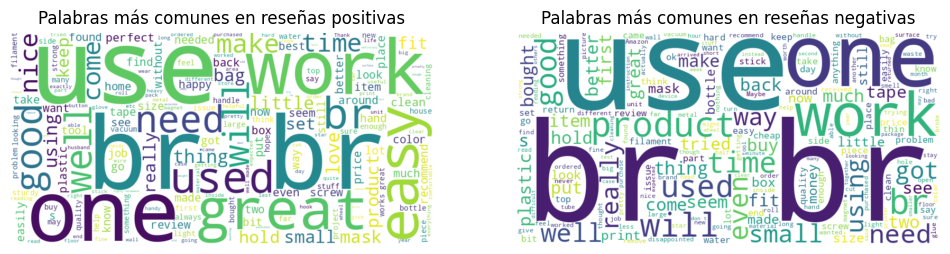

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Reseñas positivas
positive_reviews = df_clean[df_clean['sentiment_label'] == 'Positivo']['review']

# Reseñas negativas
negative_reviews = df_clean[df_clean['sentiment_label'] == 'Negativo']['review']

# Crear una nube de palabras para las reseñas positivas
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews))

# Crear una nube de palabras para las reseñas negativas
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_reviews))

# Mostrar las nubes de palabras
plt.figure(figsize=(12, 6))

# Nube de palabras positivas
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Palabras más comunes en reseñas positivas')
plt.axis('off')

# Nube de palabras negativas
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Palabras más comunes en reseñas negativas')
plt.axis('off')

plt.show()


➕ El WordCLoud positivo muestra que las palabras más comunes están relacionadas con características como "good", "use", "great", y "work", lo que indica que los usuarios están satisfechos con el rendimiento y la funcionalidad del producto. Palabras como "easy", "fit", y "great" sugieren que los productos son fáciles de usar y cumplen con las expectativas.

➖ El WordCloud negativo muestra que las palabras más frecuentes incluyen "work", "product", "need", y "well", lo que indica que los usuarios pueden estar insatisfechos con el funcionamiento del producto o con aspectos relacionados con su rendimiento. También aparece "problem" y "return", lo que sugiere que los clientes tienen problemas con el producto y en algunos casos están buscando devolverlo.

## ✅**Análisis de Polaridad y Subjetividad**

Analizaré que tan negativa o positiva es una review y que tan subjetiva u objetiva es, lo haré por medio de la librería TextBlob.

*   Puedo obtener una visión preliminar del sentimiento general de las reseñas (positivo, negativo, neutral).
*   Identificaré si las reseñas están más orientadas a hechos o a opiniones.
*   Puedo establecer umbrales para definir si las reseñas son más subjetivas o más objetivas.


Con **TextBlob** el modelo realiza un análisis básico de los reviews basado en reglas linguisticas predefinidas y un diccionario de palabras con valores que ya tiene asignados previamente. Este modelo no entiende de "contexo".


*   **Polaridad** mide qué tan positiva o negativa es una reseña, asignando un valor en el rango de [-1, 1].


  Se mide sumando puntuaciones de palabras positivas y negativas del corpus segun el diccionario interno del modelo basadas en su carga emocional.


*   **Subjetividad** mide qué tan subjetivo u objetivo es un texto, asignando un valor entre 0 (totalmente objetivo) y 1 (totalmente subjetivo).

  El modelo utiliza una lista de palabras subjetivas para identificar si es una opinion personal o un hecho objetivo.

  La subjetividad será alta (cerca a 1) sí tiene más palabras opinativas o emocionales y si tiene más palabras informativas/directas será mas baja.

In [ ]:
from textblob import TextBlob

# Calcular polaridad y subjetividad
df_clean['polarity'] = df_clean['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_clean['subjectivity'] = df_clean['review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Ver las primeras filas con los valores de polaridad y subjetividad
print(df_clean[['review', 'polarity', 'subjectivity']].head())

# Ver la distribución de polaridad y subjetividad
print("\nEstadísticas de polaridad:")
print(df_clean['polarity'].describe())
print("\nEstadísticas de subjetividad:")
print(df_clean['subjectivity'].describe())


                                              review  polarity  subjectivity
0  These masks are great even though there is no ...  0.400000      0.400000
1  These scissors are so good they got stolen by ...  0.302778      0.672222
2  Good. Sensor push easier to work with but thes...  0.600000      0.550000
3  Great ORB finish & size. Bought for our laundr...  1.000000      0.750000
4  Wow the sticking power on this stuff is crazy....  0.161667      0.826667

Estadísticas de polaridad:
count    10000.000000
mean         0.183372
std          0.296913
min         -1.000000
25%          0.000000
50%          0.153378
75%          0.350000
max          1.000000
Name: polarity, dtype: float64

Estadísticas de subjetividad:
count    10000.000000
mean         0.502855
std          0.226971
min          0.000000
25%          0.400000
50%          0.518230
75%          0.633333
max          1.000000
Name: subjectivity, dtype: float64


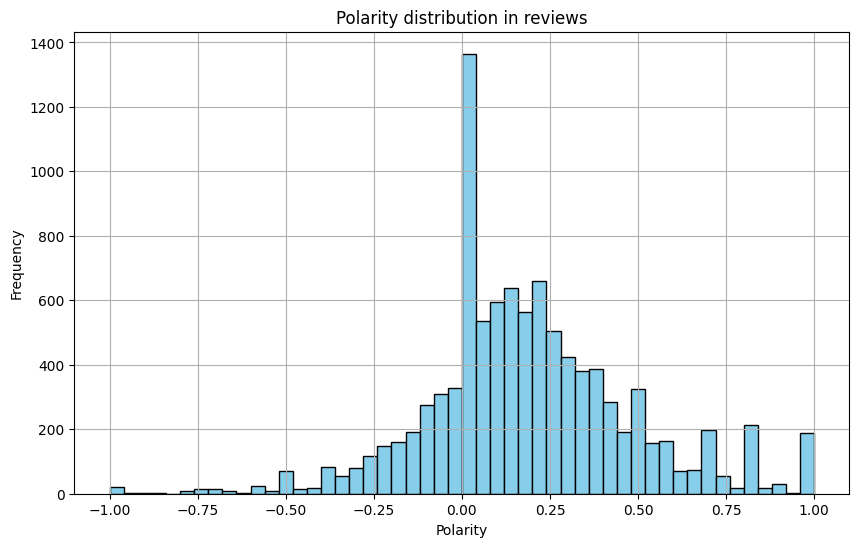

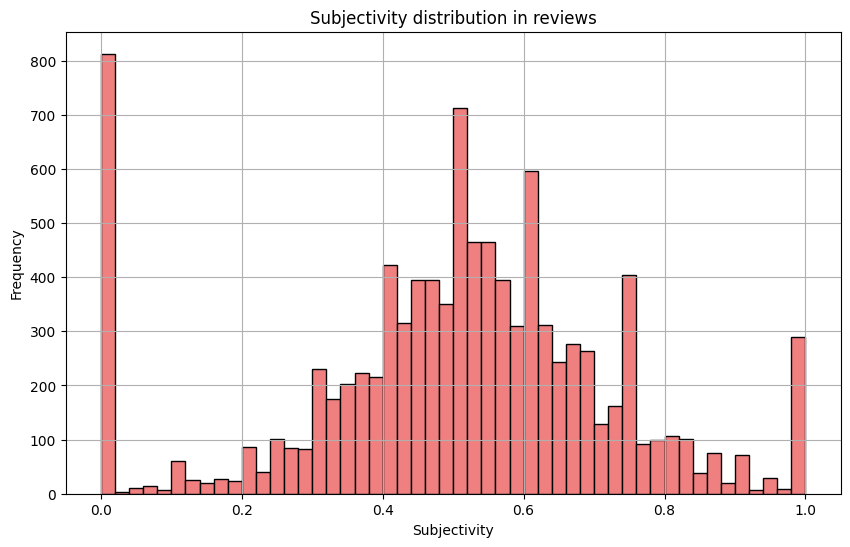

In [ ]:
import matplotlib.pyplot as plt

# Visualizar la distribución de la polaridad
plt.figure(figsize=(10, 6))
plt.hist(df_clean['polarity'], bins=50, color='skyblue', edgecolor='black')
plt.title('Polarity distribution in reviews')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualizar la distribución de la subjetividad
plt.figure(figsize=(10, 6))
plt.hist(df_clean['subjectivity'], bins=50, color='lightcoral', edgecolor='black')
plt.title('Subjectivity distribution in reviews')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### **Análisis polaridad y subjetividad:**

Se puede ver que la mayoría de las reseñas son ligeramente positivas y bastante subjetivas.


Polaridad: El valor promedio de polaridad es 0.18, lo que indica que en general las reseñas tienden a ser ligeramente positivas, pero no de manera excesiva.

Distribución: La mayoría de las reseñas están alrededor de valores cercanos a 0, lo que sugiere que muchas reseñas son ligeramente positivas o neutrales.


Subjetividad:
El valor promedio de subjetividad es 0.50, lo que significa que el corpus está equilibrado entre reseñas más subjetivas (opiniones) y objetivas (hechos).

Distribución: La mayoría de las reseñas tienen subjetividad media-alta, lo que indica que muchas reseñas son en su mayoría opiniones de los usuarios.


## ✅ **Análisis de frecuencia de términos con TF-IDF: palabras mas relevantes**

Con la técnica TF-IDF se puede indentificar **las palabras mas relevantes** en el corpus. Identifica la importancia de la palabra en un conjunto de documentos, ene este caso las reviews.

*   TF (Term Frequency): Frecuencia de la palabra en un documento.
*   IDF (Inverse Document Frequency): Mide la importancia de la palabra en el corpus. Las palabras que ocurren con frecuencia en todos los documentos tienen un IDF bajo.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear un vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=30, stop_words='english')

# Ajustar y transformar el conjunto de reseñas
X = vectorizer.fit_transform(df_clean['review'])

# Mostrar las 30 palabras más importantes según TF-IDF
print(f"30 most relevant words according to TF-IDF: {vectorizer.get_feature_names_out()}")


30 most relevant words according to TF-IDF: ['better' 'br' 'did' 'does' 'don' 'easy' 'good' 'great' 'just' 'like'
 'little' 'make' 'need' 'nice' 'plastic' 'price' 'product' 'quality'
 'really' 'recommend' 'size' 'small' 'tape' 'time' 'use' 'used' 'using'
 've' 'work' 'works']


### **Palabras relevantes**

**Palabras con carga positiva:**

Términos como "better", "good", "great", "recommend", "nice", "quality", "really", y "works" son típicamente asociados a sentimientos positivos. Esto es consistente con las reseñas que estamos analizando, ya que estas palabras probablemente aparecen con frecuencia en las reseñas positivas.

**Palabras relacionadas con el uso del producto: ***

Palabras como "use", "used", "using", "work", y "tape" están relacionadas con el funcionamiento del producto. Esto indica que los usuarios probablemente están comentando sobre cómo usan el producto o si funciona bien.

**Palabras que denotan tamaño y precio:**

"size", "small", y "price" también son relevantes, lo que sugiere que los usuarios suelen referirse a las características físicas y el costo del producto en sus reseñas.

**Palabras relacionadas con expectativas:**

Palabras como "need", "make", y "like" reflejan las expectativas de los usuarios y sus opiniones sobre si el producto cumplió con esas expectativas.

# **ETAPA DE EXPLORACION - CONCLUSIONES:**

1. **Distribución de las Reseñas por Rating:**

  La mayoría de las reseñas son positivas (rating 5), sin embargo, hay una distribución considerable de reseñas negativas (ratings 1 y 2), lo cual es relevante para el análisis de sentimientos, ya que hay una mezcla de opiniones muy positivas y negativas.

 **Preprocesado:**

  Debo asegurarme que no haya sesgo en el modelo debido a la diferencia en la cantidad de reseñas por cada rating.
  Se puede usar esta información para balancear las clases si es necesario o considerar una estrategia de muestreo para asegurarnos de que las clases estén equilibradas.

2. **Longitud de las Reseñas:**

  Algunas reseñas de mayor longitud pueden indicar que ciertos productos pueden tener instrucciones extensas que no son estrictamente reseñas de experiencia. Esto puede ser crítico si esas reseñas no contienen información relevante para el análisis de sentimientos.

  **Preprocesado:**

  Puedo considerar una estrategia de segmentación para dividir las reseñas largas en fragmentos más pequeños, especialmente si los productos incluyen instrucciones o detalles extensos.

3. **Generación de N-grams (Bigrams y Trigrams):**

  Los bigrams y trigrams más comunes están formados por stopwords y frases muy generales, lo cual no añade valor para la clasificación de sentimientos o cualquier otro análisis contextual relevante.

  **Preprocesado:**

  Podría filtrar n-grams no informativos, como las combinaciones de stopwords y frases demasiado generales (por ejemplo, "and it", "to the", "is a"), que no aportan contexto significativo.

  Tmbién se puede usar TF-IDF para ponderar la relevancia de los n-grams, y asi asegurar que el modelo se enfoque en combinaciones de palabras significativas para el contexto.

4. **WordCloud:**

  El WordCloud muestra que palabras generales como "good", "great", "use", y "easy" son muy frecuentes en las reseñas, lo que refleja una opinión mayormente positiva sobre los productos.
  
  **Preprocesado:**

  Debo considerar la eliminación de stopwords y palabras demasiado comunes que no aportan valor para el análisis.

  También asegurarme que las palabras más frecuentes sean útiles y no redundantes, y que el modelo se enfoque en términos relevantes.

5. **Modelado de Word Embeddings con Word2Vec:**

  La similitud entre las palabras positivas como "good", "great", y "nice" muestra que el modelo de Word2Vec ha capturado bien las relaciones semánticas, y que las palabras asociadas con el sentimiento positivo están agrupadas.

  Palabras relacionadas con "easy" muestran que el modelo también ha aprendido las relaciones antónimas (por ejemplo, "hard" y "difficult").
  "Product" está relacionado con términos como "item", "stuff", y "kit", lo que sugiere que el modelo ha capturado bien la variedad de descripciones de productos.

  **Preprocesado:**

  Puedo refinar el modelo de embeddings según las necesidades del análisis de sentimientos. Las relaciones semánticas entre las palabras deberían ser exploradas más a fondo antes de proceder al modelado.

  Las palabras clave asociadas con el sentimiento positivo y negativo son útiles para construir un clasificador de sentimientos, por lo que debo asegurarme de que los embeddings capturen bien estas relaciones.

6. **Distribución de las Palabras y Sentimiento en el Corpus:**

  Las palabras más comunes en el corpus están relacionadas con las características de los productos y la experiencia de uso, con un enfoque notable en la facilidad de uso, la calidad, y la satisfacción.

  **Preprocesado:**

  La clasificación de las reseñas por sentimientos debe tener en cuenta que muchas reseñas pueden contener palabras similares o términos generales que indican opiniones positivas.
  Debo asegurarme de que los n-grams relevantes se conserven y no se mezclen con términos redundantes. La eliminación de ruido en el preprocesado debe ser una prioridad.

## **Plan Preprocesamiento:**

*   Eliminar stop words y n-grams redundantes que no añaden valor semántico, utilizando TF-IDF o un diccionario de stop words.

*   Normalizar las reseñas (convertir a minúsculas, eliminar puntuación innecesaria, etc.) para evitar que variaciones de una misma palabra introduzcan ruido en el modelo.

*   Filtrar reseñas muy largas o segmentarlas si contienen texto adicional como instrucciones de producto, para evitar que esas partes sean interpretadas como contenido relevante en el análisis.

*   Las clases de sentimiento están desbalanceadas, por lo que se podría aplicar una estrategia de muestreo (submuestreo o sobremuestreo) o usar pesos en el modelo para balancear las clases.

*   Ajustar los hyperparámetros de Word2Vec (como la ventana, la cantidad de palabras mínimas, etc.) para mejorar la calidad de los embeddings y asegurar que las palabras clave sean capturadas adecuadamente.

*   Usar herramientas como t-SNE para reducir la dimensionalidad de los embeddings y observar cómo se agrupan las palabras relacionadas en el espacio vectorial.